In [1]:
# %% [Cell 1] Setup & Imports
"""
Cell 1:
- Standard imports
- Optional AI libs imported safely (no crash if not installed)
- Utility helpers
"""

import os
import warnings
from typing import List, Dict, Optional, Tuple

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    mean_squared_error,
    r2_score,
)

sns.set(style="whitegrid", rc={"figure.figsize": (10, 6)})

# Optional AI libraries — imported permissively
try:
    import openai
    _OPENAI_AVAILABLE = True
except Exception:
    openai = None
    _OPENAI_AVAILABLE = False

try:
    import google.generativeai as genai
    _GENAI_AVAILABLE = True
except Exception:
    genai = None
    _GENAI_AVAILABLE = False

print("✔ Cell 1: imports complete. AI packages available:",
      {"openai": _OPENAI_AVAILABLE, "genai": _GENAI_AVAILABLE})


✔ Cell 1: imports complete. AI packages available: {'openai': True, 'genai': True}


In [2]:
# %% [Cell 2] Load, show RAW state, Clean (if enabled), show POST-CLEAN state
"""
Cell 2:
- Load raw data to df_raw
- Print concise raw diagnostics (missing, duplicates, dtypes)
- Run smart_clean (configurable)
- Print cleaning actions and cleaned diagnostics
- Finally assign df = cleaned dataframe for downstream cells
"""

# --- Config (ensure these are set at top or here) ---
DATA_PATH = "../data/StudentsPerformanceMessy.csv"
SAMPLE_ROWS = 10000           # None = no sampling; otherwise sample to this many rows
TARGET_COL = None         # e.g., "gender" or None
AUTO_CLEAN_ENABLED = True
DROP_DUPLICATES = True
DROP_ZERO_VARIANCE = True
NUMERIC_IMPUTE_METHOD = "median"
CATEGORICAL_IMPUTE = "mode"
RARE_CATEGORY_THRESHOLD = 0.01
AI_PROVIDER: Optional[str] = "gemini"       # "openai" | "gemini" | None
AI_API_KEY: str = ""         # set your key if enabling AI
AI_MODEL: Optional[str] = None          # let the code pick sensible default if None

# --- Helpers ---
import math
from collections import Counter
def short_report(df):
    return {
        "shape": df.shape,
        "n_missing_total": int(df.isnull().sum().sum()),
        "n_duplicates": int(df.duplicated().sum()),
        "n_numeric": int(df.select_dtypes(include=[np.number]).shape[1]),
        "n_categorical": int(df.select_dtypes(include=['object','category']).shape[1]),
        "dtypes": df.dtypes.apply(lambda x: str(x)).to_dict()
    }

def show_basic_state(df, name="Data"):
    print(f"\n{'='*10} {name} STATE {'='*10}\n")
    rep = short_report(df)
    print(f"Shape: {rep['shape']}")
    print(f"Total missing cells: {rep['n_missing_total']}")
    print(f"Duplicate rows: {rep['n_duplicates']}")
    print(f"Numeric cols: {rep['n_numeric']}, Categorical cols: {rep['n_categorical']}")
    # show top missing columns
    miss_cols = df.isnull().sum().sort_values(ascending=False).head(10)
    print("\nMissing columns:")
    display(miss_cols[miss_cols>0].head(20))
    # show duplicates
    print("\nDuplicates:")
    display(df[df.duplicated(keep=False)>0].head(10))
    # show dtypes summary
    print("\nData types:")
    display(pd.Series(rep['dtypes']).head(20))
    print("\nSample rows:")
    display(df.head(5))

# --- Load raw data ---
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Data file not found: {DATA_PATH}")

ext = os.path.splitext(DATA_PATH)[1].lower()
if ext == ".csv":
    df_raw = pd.read_csv(DATA_PATH)
elif ext in [".xlsx",".xls"]:
    df_raw = pd.read_excel(DATA_PATH)
elif ext == ".parquet":
    df_raw = pd.read_parquet(DATA_PATH)
else:
    raise ValueError("Unsupported file type: " + ext)

# sampling if needed
if SAMPLE_ROWS and len(df_raw) > SAMPLE_ROWS:
    df_raw = df_raw.sample(n=SAMPLE_ROWS, random_state=42).reset_index(drop=True)

# show raw state
show_basic_state(df_raw, "RAW")

# --- Cleaning function (robust, non-destructive) ---
def infer_datetime_columns_local(df, sample_n=500):
    df = df.copy()
    for col in df.columns:
        if df[col].dtype == object:
            sample = df[col].dropna().astype(str).head(sample_n)
            if sample.str.contains(r"[-/T]").any() or sample.str.contains(r"\d{4}").any():
                try:
                    parsed = pd.to_datetime(df[col], errors='coerce', infer_datetime_format=True)
                    if parsed.notna().sum() / max(1, len(df)) > 0.6:
                        df[col] = parsed
                except Exception:
                    pass
    return df

def smart_clean_local(df):
    # returns (cleaned_df, actions_report)
    report = {"orig_shape": df.shape, "actions": [], "final_shape": None}
    d = df.copy()

    # 1) remove duplicates (optional)
    if DROP_DUPLICATES:
        before = len(d)
        d = d.drop_duplicates().reset_index(drop=True)
        removed = before - len(d)
        report["actions"].append({"duplicates_removed": int(removed)})
    else:
        report["actions"].append({"duplicates_removed": 0})

    # 2) infer datetimes
    before_types = d.dtypes.apply(lambda x: str(x)).to_dict()
    d = infer_datetime_columns_local(d)
    after_types = d.dtypes.apply(lambda x: str(x)).to_dict()
    changed = {c: {"before": before_types[c], "after": after_types[c]} for c in d.columns if before_types.get(c)!=after_types.get(c)}
    if changed:
        report["actions"].append({"dtype_inferred": changed})

    # 3) drop zero-variance columns (optional)
    if DROP_ZERO_VARIANCE:
        zero_var = [c for c in d.columns if d[c].nunique(dropna=True) <= 1]
        if zero_var:
            d = d.drop(columns=zero_var)
            report["actions"].append({"dropped_zero_variance": zero_var})

    # 4) impute numeric
    num_cols = d.select_dtypes(include=[np.number]).columns.tolist()
    for c in num_cols:
        if d[c].isnull().any():
            if NUMERIC_IMPUTE_METHOD == "median":
                val = d[c].median()
            else:
                val = d[c].mean()
            d[c] = d[c].fillna(val)
            report["actions"].append({"impute_numeric": {c: float(val) if not pd.isna(val) else None}})

    # 5) impute categorical
    cat_cols = d.select_dtypes(include=['object','category']).columns.tolist()
    for c in cat_cols:
        if d[c].isnull().any():
            if CATEGORICAL_IMPUTE == "mode":
                try:
                    val = d[c].mode(dropna=True)[0]
                except Exception:
                    val = "__MISSING__"
            else:
                val = "__MISSING__"
            d[c] = d[c].fillna(val)
            report["actions"].append({"impute_categorical": {c: val}})

    # 6) rare grouping
    for c in cat_cols:
        freqs = d[c].value_counts(normalize=True)
        rare = freqs[freqs < RARE_CATEGORY_THRESHOLD].index.tolist()
        if rare:
            d[c] = d[c].apply(lambda x: "__RARE__" if x in rare else x)
            report["actions"].append({"rare_grouped": {c: len(rare)}})

    report["final_shape"] = d.shape
    return d, report

# --- Run cleaning if enabled ---
if AUTO_CLEAN_ENABLED:
    df_cleaned, cleaning_report = smart_clean_local(df_raw)
    print("\nCleaning performed. Actions summary:")
    display(cleaning_report)
else:
    df_cleaned = df_raw.copy()
    cleaning_report = {"auto_cleaning": "disabled"}
    print("\nAuto cleaning disabled by config.")

# show post-clean state (this is what downstream cells should use)
show_basic_state(df_cleaned, "POST-CLEAN")

# finally set df for downstream cells
df = df_cleaned



========== RAW STATE ==========

Shape: (1000, 8)
Total missing cells: 1
Duplicate rows: 1
Numeric cols: 3, Categorical cols: 5

Missing columns:


,0
test preparation course,1



Duplicates:


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
9,female,group B,high school,free/reduced,none,38,60,50
10,female,group B,high school,free/reduced,none,38,60,50



Data types:


,0
gender,object
race/ethnicity,object
parental level of education,object
lunch,object
test preparation course,object
math score,int64
reading score,int64
writing score,int64



Sample rows:


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,NaN,76,78,75



Cleaning performed. Actions summary:


{'orig_shape': (1000, 8),
 'actions': [{'duplicates_removed': 1},
  {'impute_categorical': {'test preparation course': 'none'}}],
 'final_shape': (999, 8)}


========== POST-CLEAN STATE ==========

Shape: (999, 8)
Total missing cells: 0
Duplicate rows: 0
Numeric cols: 3, Categorical cols: 5

Missing columns:


,0



Duplicates:


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score



Data types:


,0
gender,object
race/ethnicity,object
parental level of education,object
lunch,object
test preparation course,object
math score,int64
reading score,int64
writing score,int64



Sample rows:


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


SECTION: Numeric distributions (histograms)


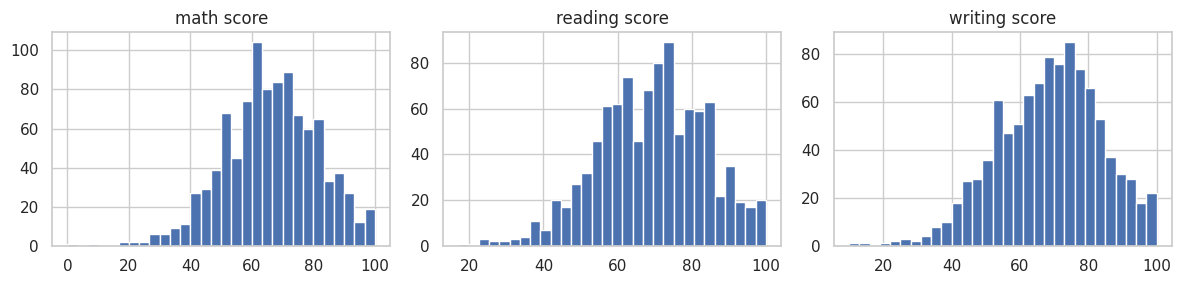



SECTION: Boxplots (top variance numeric features)


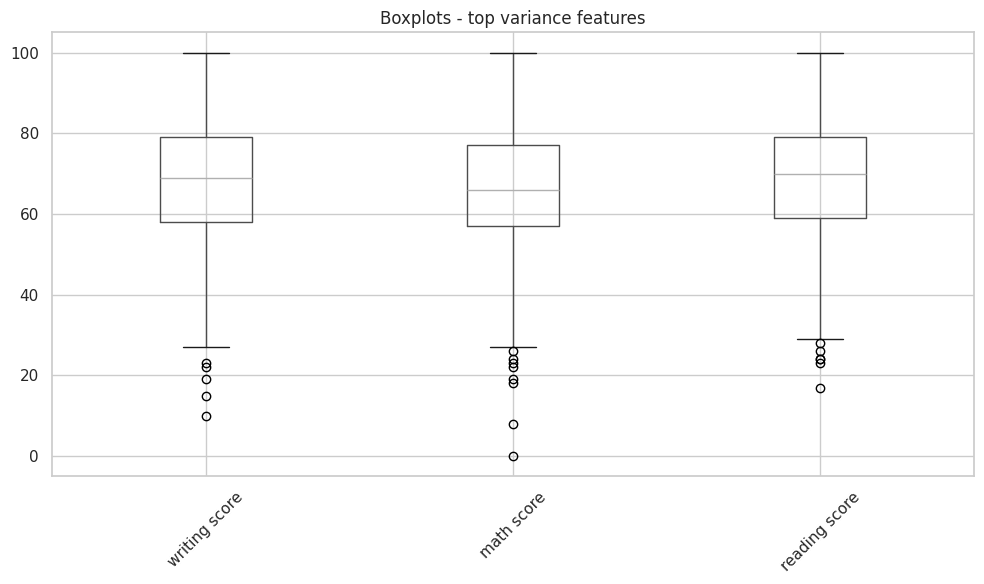



SECTION: Categorical distributions (top categories)


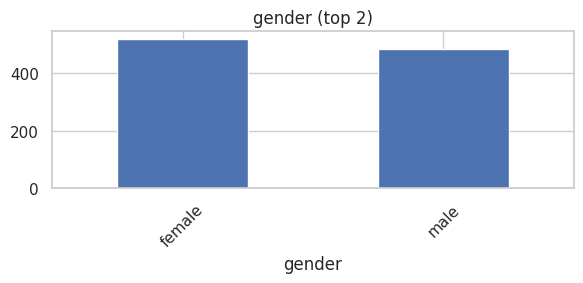

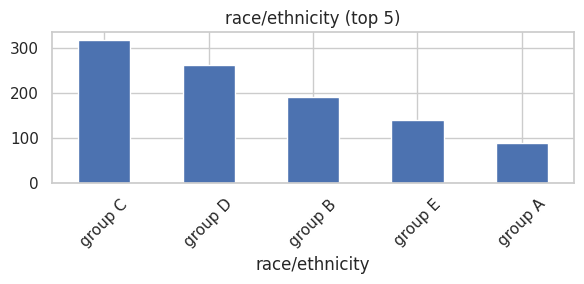

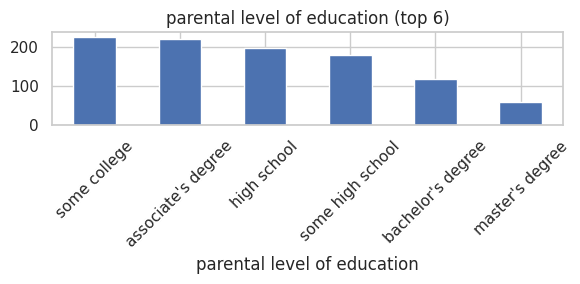

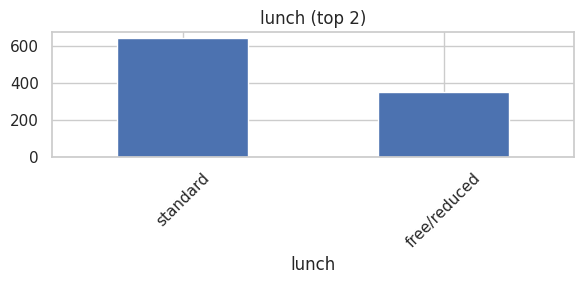

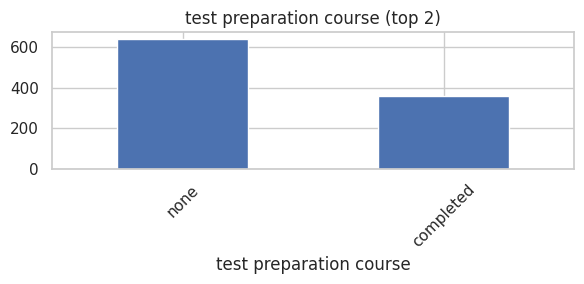





SECTION: Correlation heatmap


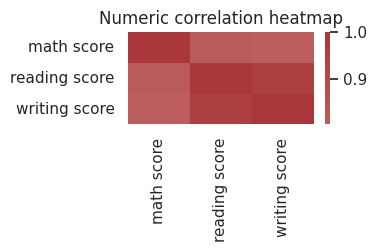

Top correlated pairs (abs correlation):
reading score <> writing score: 0.955
math score <> reading score: 0.818
math score <> writing score: 0.803


SECTION: Target-aware visuals


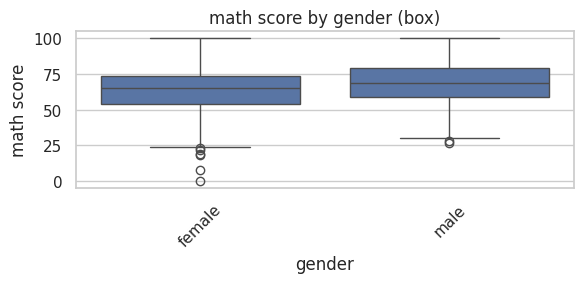

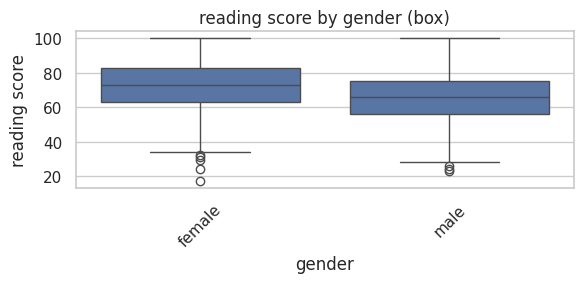

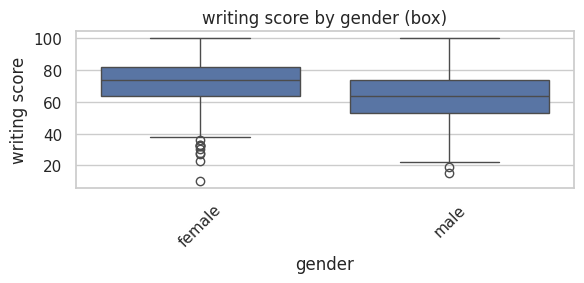





No datetime columns to check.


End of visual EDA.


In [3]:
# %% [Cell 3] Rich EDA & Visualizations (runs on cleaned df)
"""
Cell 3:
- Runs a full exploratory analysis on the cleaned dataframe `df`
- Includes spacing between sections for readability
- Visuals: histograms, boxplots, top categorical bars, correlation heatmap, target vs numeric boxplots
"""

import matplotlib.ticker as ticker

def sep():
    print("\n" + "="*100 + "\n")

def newline():
    print("\n")

# 1) Numeric distributions: histograms + boxplots for top numerics
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if num_cols:
    print("SECTION: Numeric distributions (histograms)")
    # histograms in a grid
    n = len(num_cols)
    cols = min(4, n)
    rows = math.ceil(n/cols)
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows))
    axes = axes.flatten() if hasattr(axes, 'flatten') else [axes]
    for i, c in enumerate(num_cols):
        ax = axes[i]
        df[c].hist(bins=30, ax=ax)
        ax.set_title(c)
    for j in range(i+1, len(axes)):
        axes[j].axis('off')
    plt.tight_layout()
    plt.show()
    sep()

    # Boxplots for top-6 numeric columns by variance
    top_vars = df[num_cols].var().sort_values(ascending=False).head(6).index.tolist()
    print("SECTION: Boxplots (top variance numeric features)")
    fig, ax = plt.subplots(1,1, figsize=(10,6))
    df[top_vars].boxplot()
    plt.xticks(rotation=45)
    plt.title("Boxplots - top variance features")
    plt.tight_layout()
    plt.show()
    sep()
else:
    print("No numeric columns to visualize.")
    sep()

# 2) Categorical top-k bar charts
cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()
if cat_cols:
    print("SECTION: Categorical distributions (top categories)")
    for c in cat_cols:
        vc = df[c].value_counts().head(10)
        if vc.size == 0:
            continue
        fig, ax = plt.subplots(figsize=(6,3))
        vc.plot(kind='bar', ax=ax)
        ax.set_title(f"{c} (top {min(10, vc.size)})")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        newline()
    sep()
else:
    print("No categorical columns to visualize.")
    sep()

# 3) Correlation heatmap + top correlated pairs
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if len(num_cols) >= 2:
    print("SECTION: Correlation heatmap")
    corr = df[num_cols].corr()
    plt.figure(figsize=(min(12, len(num_cols)), min(10, len(num_cols)*0.4)))
    sns.heatmap(corr, cmap='vlag', center=0)
    plt.title("Numeric correlation heatmap")
    plt.show()

    # show top pairs programmatically
    abs_corr = corr.abs()
    pairs = []
    cols = abs_corr.columns
    for i,a in enumerate(cols):
        for b in cols[i+1:]:
            pairs.append((a,b,abs_corr.loc[a,b]))
    top_pairs = sorted(pairs, key=lambda x: x[2], reverse=True)[:10]
    print("Top correlated pairs (abs correlation):")
    for a,b,v in top_pairs:
        print(f"{a} <> {b}: {v:.3f}")
    sep()
else:
    print("Not enough numeric columns for correlation analysis.")
    sep()

# 4) Target-aware visuals (if target present)
if TARGET_COL and TARGET_COL in df.columns:
    print("SECTION: Target-aware visuals")
    y = df[TARGET_COL]
    # numeric predictors vs target boxplots (if target numeric, scatter + reg; if categorical, box)
    for c in num_cols:
        fig, ax = plt.subplots(1,1, figsize=(6,3))
        if pd.api.types.is_numeric_dtype(y):
            ax.scatter(df[c], y, alpha=0.3)
            ax.set_xlabel(c); ax.set_ylabel(TARGET_COL)
            ax.set_title(f"{c} vs {TARGET_COL} (scatter)")
        else:
            sns.boxplot(x=df[TARGET_COL], y=df[c], ax=ax)
            ax.set_title(f"{c} by {TARGET_COL} (box)")
            plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        newline()
    sep()
else:
    print("No target configured; skipping target visuals.")
    sep()

# 5) Datetime quick checks
dt_cols = df.select_dtypes(include=['datetime64[ns]']).columns.tolist()
if dt_cols:
    print("SECTION: Datetime checks")
    for c in dt_cols:
        s = df[c].dropna()
        print(f"{c}: range {s.min()} -> {s.max()}, unique {s.nunique()}")
        # sample daily counts
        try:
            counts = s.dt.to_period('D').value_counts().sort_index().head(30)
            fig, ax = plt.subplots(figsize=(10,3))
            counts.plot(ax=ax)
            ax.set_title(f"{c} - sample daily counts")
            plt.tight_layout()
            plt.show()
        except Exception:
            pass
    sep()
else:
    print("No datetime columns to check.")
    sep()

print("End of visual EDA.")


In [4]:
# %% [Cell 4] Target-aware analysis & baseline ML
"""
Cell 4:
- Detect task type (classification vs regression)
- Produce target-profiling and baseline model with feature importances
- Gracefully skip if no target
"""

def target_summary(df: pd.DataFrame, target: str):
    print("SECTION: Target summary")
    y = df[target]
    display(pd.DataFrame({
        "dtype": [y.dtype],
        "n_unique": [y.nunique()],
        "missing": [y.isna().sum()],
    }, index=[target]))
    print()
    print("Value counts (top 20):")
    display(y.value_counts().head(20))
    print()

def prepare_model_data(df: pd.DataFrame, target: str):
    X = df.drop(columns=[target])
    # Only numeric features for quick baseline; user can extend later
    X_num = X.select_dtypes(include=[np.number]).copy()
    if X_num.shape[1] == 0:
        raise ValueError("No numeric predictors available for baseline modeling.")
    X_num = X_num.fillna(0)
    y = df[target]
    return X_num, y

def baseline_model(df: pd.DataFrame, target: str):
    # detect task
    y = df[target]
    is_classification = (y.nunique() <= 20) and (not pd.api.types.is_float_dtype(y))
    print("Detected task:", "classification" if is_classification else "regression")
    X, y = prepare_model_data(df, target)
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=42)

    if is_classification:
        clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
        clf.fit(Xtrain, ytrain)
        preds = clf.predict(Xtest)
        try:
            proba = clf.predict_proba(Xtest)[:, 1] if len(clf.classes_) == 2 else None
        except Exception:
            proba = None
        print("Classification report:")
        print(classification_report(ytest, preds))
        if proba is not None:
            try:
                auc = roc_auc_score(ytest, proba)
                print("ROC AUC:", round(auc, 4))
            except Exception:
                pass
        importances = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
        print("\nTop feature importances:")
        display(importances.head(20))
        # cross-validated score (accuracy)
        try:
            cv_scores = cross_val_score(clf, X, y, cv=3, scoring="accuracy", n_jobs=-1)
            print("CV accuracy (3-fold):", np.round(cv_scores, 4))
        except Exception:
            pass
    else:
        reg = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
        reg.fit(Xtrain, ytrain)
        preds = reg.predict(Xtest)
        print("Regression metrics:")
        print("MSE:", round(mean_squared_error(ytest, preds), 4))
        print("R2:", round(r2_score(ytest, preds), 4))
        importances = pd.Series(reg.feature_importances_, index=X.columns).sort_values(ascending=False)
        print("\nTop feature importances:")
        display(importances.head(20))
        try:
            cv_scores = cross_val_score(reg, X, y, cv=3, scoring="r2", n_jobs=-1)
            print("CV r2 (3-fold):", np.round(cv_scores, 4))
        except Exception:
            pass

# Execute only if target specified
if TARGET_COL and TARGET_COL in df.columns:
    try:
        target_summary(df, TARGET_COL)
        baseline_model(df, TARGET_COL)
    except Exception as e:
        print("Baseline modeling skipped due to error:", e)
else:
    print("No target configured or target not found; skipping baseline ML.")


SECTION: Target summary


,dtype,n_unique,missing
gender,object,2,0



Value counts (top 20):


,count
gender,
female,518
male,481



Detected task: classification
Classification report:
              precision    recall  f1-score   support

      female       0.85      0.83      0.84       127
        male       0.83      0.85      0.84       123

    accuracy                           0.84       250
   macro avg       0.84      0.84      0.84       250
weighted avg       0.84      0.84      0.84       250

ROC AUC: 0.9275

Top feature importances:


,0
math score,0.411024
writing score,0.330839
reading score,0.258137


CV accuracy (3-fold): [0.8468 0.8198 0.8468]


In [5]:
# %% [Cell 5] Insight Engine (Informative) — corrected severity labels
"""
Cell 5:
- Deterministic rules produce warnings/errors where appropriate
- Uses cleaning_report from Cell 2 to report pre-clean issues vs post-clean result
- Always produces positive confirmations if no issues remain
- AI summarization remains optional via AI_PROVIDER and AI_API_KEY
"""

INSIGHTS = []

def add_insight(text: str, severity: str = "info"):
    # severity must be one of 'info','warning','error'
    severity = severity if severity in ('info','warning','error') else 'info'
    INSIGHTS.append({"text": text, "severity": severity})

def severity_for_missing(count):
    if count == 0:
        return "info"
    elif count < 20:
        return "warning"
    else:
        return "error"

def run_rules_post_clean(df, cleaning_report=None, target_col: Optional[str]=None):
    INSIGHTS.clear()

    # 1) Report pre-clean issues if available in cleaning_report
    try:
        if cleaning_report and isinstance(cleaning_report, dict):
            # if duplicates were removed, warn that duplicates existed originally
            dup_action = next((a for a in cleaning_report.get("actions", []) if "duplicates_removed" in a), None)
            if dup_action and dup_action.get("duplicates_removed", 0) > 0:
                add_insight(f"Duplicates were present and removed: {dup_action['duplicates_removed']}", "warning")
            # dtype inference notes
            dtype_actions = next((a for a in cleaning_report.get("actions", []) if "dtype_inferred" in a), None)
            if dtype_actions:
                add_insight(f"Dtype inference performed on columns: {list(dtype_actions['dtype_inferred'].keys())}", "info")
    except Exception:
        pass

    # 2) Missingness after clean
    total_missing = int(df.isnull().sum().sum())
    add_insight(f"Total missing cells (post-clean): {total_missing}", severity_for_missing(total_missing))

    # 3) Duplicates after clean
    dup_count = int(df.duplicated().sum())
    add_insight(f"Duplicate rows present (post-clean): {dup_count}", "warning" if dup_count>0 else "info")

    # 4) Low variance columns
    low_var = [c for c in df.columns if df[c].nunique(dropna=True) <= 1]
    if low_var:
        add_insight(f"Low/zero variance columns (consider dropping): {low_var}", "warning")
    else:
        add_insight("No zero-variance columns detected.", "info")

    # 5) Cardinality cautions
    cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()
    high_card = [c for c in cat_cols if df[c].nunique() > 200]
    if high_card:
        add_insight(f"High-cardinality categorical columns: {high_card}", "warning")
    else:
        if cat_cols:
            add_insight(f"Categorical columns OK (count={len(cat_cols)}).", "info")

    # 6) Skewness / outlier check
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    skewed = []
    outlier_cols = []
    for c in num_cols:
        s = df[c].dropna()
        if s.size < 10:
            continue
        sk = s.skew()
        if abs(sk) > 2.0:
            skewed.append((c, round(sk,3)))
        # IQR outliers
        q1,q3 = s.quantile(0.25), s.quantile(0.75)
        iqr = q3-q1
        if iqr>0:
            out_pct = ((s < (q1 - 3*iqr)) | (s > (q3 + 3*iqr))).mean()
            if out_pct > 0.01:
                outlier_cols.append((c, round(out_pct*100,3)))
    if skewed:
        add_insight(f"Highly skewed numeric columns: {skewed}", "warning")
    else:
        add_insight("No extremely skewed numeric columns detected.", "info")
    if outlier_cols:
        add_insight(f"Columns with >1% extreme outliers: {outlier_cols}", "warning")

    # 7) Strong correlations
    if len(num_cols) >= 2:
        corr = df[num_cols].corr().abs()
        strong = []
        cols = corr.columns
        for i,a in enumerate(cols):
            for b in cols[i+1:]:
                if corr.loc[a,b] > 0.9:
                    strong.append((a,b, round(corr.loc[a,b],3)))
        if strong:
            add_insight(f"Strongly correlated pairs detected (|r|>0.9): {strong}", "warning")
        else:
            add_insight("No extremely strong numeric correlations (>0.9) detected.", "info")

    # 8) Target checks
    if target_col and target_col in df.columns:
        y = df[target_col]
        if y.nunique() <= 1:
            add_insight("Target has <=1 unique value — error for modeling.", "error")
        else:
            add_insight(f"Target '{target_col}' usable (n_unique={y.nunique()}).", "info")
            if not pd.api.types.is_numeric_dtype(y):
                vc = y.value_counts(normalize=True)
                top_pct = vc.iloc[0]
                if top_pct > 0.9:
                    add_insight(f"Severe class imbalance: top class {round(top_pct*100,2)}%", "warning")
                elif top_pct > 0.7:
                    add_insight(f"Notable class imbalance: top class {round(top_pct*100,2)}%", "info")
                else:
                    add_insight("Target class balance OK.", "info")

    # 9) Final summary positive message if few warnings/errors
    n_warn = sum(1 for i in INSIGHTS if i['severity']=="warning")
    n_err = sum(1 for i in INSIGHTS if i['severity']=="error")
    if n_err == 0 and n_warn == 0:
        add_insight("No issues detected. Dataset looks healthy.", "info")
    else:
        add_insight(f"Summary: {n_err} error(s), {n_warn} warning(s) found.", "info")

    return INSIGHTS

# AI summary function
def ai_summarize(insights: List[Dict]) -> str:
    if AI_PROVIDER is None:
        return "AI summary disabled (AI_PROVIDER is None)."

    if not AI_API_KEY:
        return "AI summary configured but AI_API_KEY not set."

    # Build prompt
    text = "\n".join(f"- {i['text']} ({i['severity']})" for i in insights[:50])
    prompt = (
        "You are a succinct data analysis assistant. Given the following EDA insights, "
        "produce a concise 6-bullet summary emphasizing errors, quick fixes, and modeling suggestions.\n\n"
        f"{text}"
    )

    # OpenAI path
    if AI_PROVIDER == "openai":
        if not _OPENAI_AVAILABLE or openai is None:
            return "OpenAI SDK not installed; cannot produce AI summary."
        try:
            openai.api_key = AI_API_KEY
            model = AI_MODEL or "gpt-4.1-mini"
            resp = openai.ChatCompletion.create(
                model=model,
                messages=[
                    {"role": "system", "content": "You are a data science expert."},
                    {"role": "user", "content": prompt},
                ],
                max_tokens=400,
            )
            return resp["choices"][0]["message"]["content"].strip()
        except Exception as e:
            return f"AI summary failed (OpenAI): {e}"

    # Gemini path
    if AI_PROVIDER == "gemini":
        if not _GENAI_AVAILABLE or genai is None:
            return "Gemini SDK not installed; cannot produce AI summary."
        try:
            genai.configure(api_key=AI_API_KEY)
            model = AI_MODEL or "gemini-2.5-flash"
            response = genai.GenerativeModel(model).generate_content(prompt)
            return response.text.strip()
        except Exception as e:
            return f"AI summary failed (Gemini): {e}"

    return "AI provider not recognized."

# Run and display
ins = run_rules_post_clean(df, cleaning_report=cleaning_report, target_col=TARGET_COL)
ins_df = pd.DataFrame(ins)
# small fix: ensure severity column exists and print grouped counts
display(ins_df)
print("\nCounts by severity:")
print(ins_df['severity'].value_counts().to_dict())

# AI summary if enabled (reuse ai_summarize function if present)
try:
    ai_text = ai_summarize(ins) if 'ai_summarize' in globals() else "AI summarizer not present in this notebook."
except Exception as e:
    ai_text = f"AI summarizer failed: {e}"

print("\nAI SUMMARY (if enabled/configured):")
print(ai_text)


,text,severity
0,Duplicates were present and removed: 1,warning
1,Total missing cells (post-clean): 0,info
2,Duplicate rows present (post-clean): 0,info
3,No zero-variance columns detected.,info
4,Categorical columns OK (count=5).,info
5,No extremely skewed numeric columns detected.,info
6,Strongly correlated pairs detected (|r|>0.9): ...,warning
7,Target 'gender' usable (n_unique=2).,info
8,Target class balance OK.,info
9,"Summary: 0 error(s), 2 warning(s) found.",info



Counts by severity:
{'info': 8, 'warning': 2}

AI SUMMARY (if enabled/configured):
Here's a concise 6-bullet summary:

*   One duplicate row was identified and removed.
*   Strong multicollinearity exists between 'reading score' and 'writing score' (r=0.955).
*   **Quick Fix:** To address multicollinearity, consider dropping one of the highly correlated features (e.g., 'writing score').
*   **Modeling Suggestion:** Alternatively, use PCA to handle multicollinearity if preserving feature information is critical.
*   **Modeling Suggestion:** The 'gender' target is balanced and suitable for binary classification.
*   No other major data quality issues (missing values, zero-variance columns, extreme skew, or categorical problems) were detected.
